# Module 5: Regime Prediction with Machine Learning - Part 3

In this part we are going to predict economic regimes with machine learning algorithms using Pyhton's Scikit Learn package.

## Table of Contents:
&nbsp;&nbsp;1. [Set Up Environment and Read Data](#1)
   
&nbsp;&nbsp;2. [Methodology](#2)   

&nbsp;&nbsp;3. [Feature Selection](#3)   

&nbsp;&nbsp;4. [Traning Algorithms on Training Dataset](#4)

&nbsp;&nbsp;5. [Evaluate Performances of the Algorithms on Validation Dataset](#5)

## 1. Set Up Environment and Read Data <a id="1"></a>

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from matplotlib import pyplot as mp
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [53]:
df=pd.read_csv('final.csv')


df.head()


,BCAXF_BP6_USD,FIGB_PA,credit_government,credit_private,debt_service,House_prices,gdp_growth,credit_growth,inflation,stock_growth,...,Country_FR,Country_GB,Country_GR,Country_IE,Country_IT,Country_LU,Country_NL,Country_PT,Country_SE,three_year
0,85.684011,8.793333,69.05,66.7,17.25,94.555347,0.023665,0.057052,0.038722,-0.096701,...,0,0,0,0,0,0,0,0,0,0.0
1,85.684011,8.670000,69.05,88.0,17.25,94.555347,0.023665,0.052632,0.056423,0.117380,...,0,0,0,0,0,0,0,0,0,0.0
2,2779.865127,5.366667,69.05,89.1,17.25,94.555347,0.023665,0.011351,0.030010,0.109239,...,0,0,0,0,0,0,0,0,0,0.0
3,-547.348907,5.846667,69.05,122.0,17.25,94.555347,0.023665,-0.011345,0.126301,0.117380,...,0,0,0,0,0,0,0,0,0,0.0
4,66.384640,5.846667,69.05,87.6,17.25,106.158058,0.023665,0.052885,0.094163,-0.116022,...,0,0,0,0,0,0,0,0,0,0.0


In [54]:
df.tail()

,BCAXF_BP6_USD,FIGB_PA,credit_government,credit_private,debt_service,House_prices,gdp_growth,credit_growth,inflation,stock_growth,...,Country_FR,Country_GB,Country_GR,Country_IE,Country_IT,Country_LU,Country_NL,Country_PT,Country_SE,three_year
2126,18254.188114,1.883333,147.3,112.2,10.40,94.820815,0.016421,-0.024348,0.009327,0.296768,...,0,0,0,0,1,0,0,0,0,0.0
2127,3199.663988,5.846667,24.4,401.8,17.25,106.330668,0.030472,-0.059016,0.015964,0.048366,...,0,0,0,0,0,1,0,0,0,0.0
2128,26831.443043,0.487000,64.0,275.4,27.90,110.560425,0.025529,-0.037063,0.013608,0.170100,...,0,0,0,0,0,0,1,0,0,0.0
2129,628.621802,5.846667,137.1,176.4,16.20,112.045034,0.032800,-0.040261,0.014690,0.209807,...,0,0,0,0,0,0,0,1,0,0.0
2130,4302.301547,5.846667,43.2,238.4,20.70,107.595216,-0.005248,0.024495,0.017651,0.117958,...,0,0,0,0,0,0,0,0,1,0.0


## 2. Methodology <a id="2"></a>

Our exercise will be based on classification problem. We have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms.

1. We will perform feature selection before making our forecasts. We will use $L_1$ regularized logistic regression for that purpose.

2. Separate dataset into training and validation datasets. Split based dataset based on time: the period over 1960-1996 is selected for training and the period over 1996-2018 is kept for validation

3. Evaluate performances of the machine learning algorithms on training dataset with cross validation (CV). Since we have time series structure we will use a special type of CV function in Python,__[`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)__. We will use Receiver operating characteristic (ROC) as scoring metric in our models. Related Python functions for this metric are __[`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)__  and  __[`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)__.

4. Select the best performing models based on average accuracy and standard deviation of the CV results. We will take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem.

5. Then we make predictions on the validation dataset with selected models. First, we use __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ for selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on validation dataset and report accuracy metrics and feature importance results.

## 3. Feature Selection with $L_1$ Penalty <a id="3"></a>

In [55]:
# Time Series Split
df_idx = df[df.date == '2005-01-01'].index[0]

df_targets=df['three_year'].values
df_features=df.drop(['date','three_year'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['date','three_year'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['date','three_year'], axis=1)

df_training_targets = df['three_year'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['three_year'].values
df_validation_targets=df_validation_targets[df_idx:]



In [56]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

1520 1520 2131
611 611 2131


In [57]:
scoring="roc_auc"
kfold= model_selection.TimeSeriesSplit(n_splits=3)
seed=8

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C)

model=LogisticRegression(max_iter=10000,penalty='l1')
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(X=df_features,
                                                                       y=df_targets).best_estimator_

LR_penalty

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
X=df_features
y=df_targets
lr_l1 = LogisticRegression(C=0.1, max_iter=10000,penalty="l1").fit(X,y)
model = SelectFromModel(lr_l1,prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = model.transform(X)
X_new.shape

(2131, 9)

In [59]:
feature_name

Index(['BCAXF_BP6_USD', 'FIGB_PA', 'credit_government', 'credit_private',
       'debt_service', 'House_prices', 'credit_gap', 'house_gap',
       'Country_GB'],
      dtype='object')

In [60]:
df_2=df[feature_name]
df_2.insert(loc=0, column="date", value=df['date'].values)
df_2.insert(loc=1, column='three_year', value=df['three_year'].values)

df_2.head()
df_2.shape

(2131, 11)

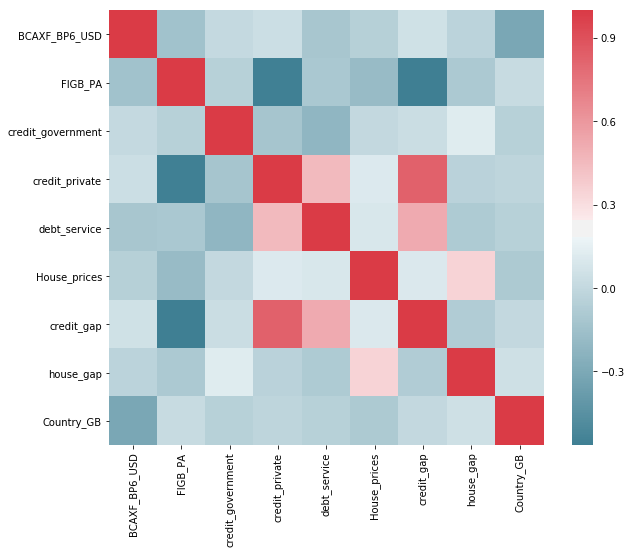

In [61]:
corr = df_2.drop(['date','three_year'],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## 4. Training Algorithms on Training Dataset <a id="3"></a>

For a detail description of the machine learning algorithms you can check scikit-learn's documentation __[here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)__.

In [62]:
df=df_2
df.shape

(2131, 11)

In [63]:
# Time Series Split
df_idx = df[df.date == '2005-01-01'].index[0]

df_targets=df['three_year'].values
df_features=df.drop(['date','three_year'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['date','three_year'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['date','three_year'], axis=1)

df_training_targets = df['three_year'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['three_year'].values
df_validation_targets=df_validation_targets[df_idx:]







LR: 0.668380 (0.221138)
LR_L1: 0.654063 (0.223421)
LR_L2: 0.651555 (0.220009)
LDA: 0.638375 (0.196695)
KNN: 0.597013 (0.081521)
GB: 0.690882 (0.294646)
ABC: 0.636969 (0.212055)
RF: 0.685001 (0.134401)
XGB: 0.801103 (0.109748)


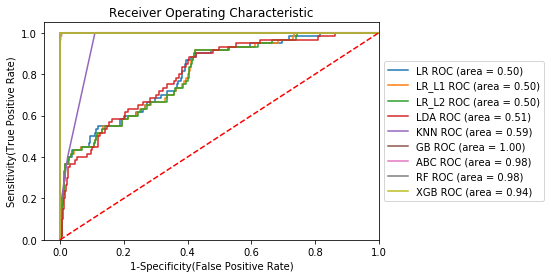

In [86]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=4) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

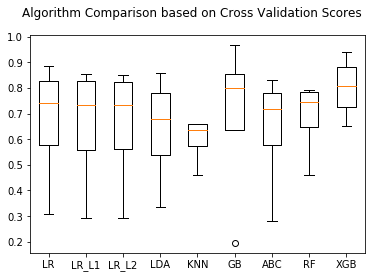

In [87]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

Logistic regression is the most commonly used statistical model for binary classification. It uses the logit model of relating log-odds of the dependent variable linearly with the predictor (explanatory) variables to learn a form of the following logistic function that is used to separate instances of the two different classes. 

\begin{align*}
Pr(y=1|x) = h_\beta(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  x)}} \text{ where $\beta_0$ is the intercept and $\beta$ is the vector of trained weights}
\end{align*}

The function returns a probability measure of which class a new instance is given its features, this measure is then used to make the final classification with some probability threshold, traditionally being 0.5.

The specific logistic function is learned through gradient descent which focuses on minimizing error calculated through some cost function. A typical approach is to use the following maximum-likelihood estimator to minimize error in predicted probabilities.

\begin{align*}
& J(\beta) = -\frac{1}{N}\sum_{i=1}^Ny_ilog(h_\beta(x_i)) + (1 - y_i)log(1 - h_\beta(x_i)) \\
& \text{ where $N$ is the number of observations, $h_\beta(x)$ is as defined above, and $y_i$ is the predicted class}
\end{align*}

A regularization term 

\begin{align*}
\lambda\sum_{i=1}^N|\beta_i| \text{ where $\lambda$ is a regularization parameter, }
\end{align*}

is often added to the cost function to prevent overfitting by penalizing large coefficients. This regularization can be L1 or L2 penalty depending on the problem at hand.

In [88]:
model=LogisticRegression(C=1e09) # high penalty 
LR=model.fit(df_training_features,df_training_targets)
training_predictions=LR.predict(df_training_features)
prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)

In [122]:
from sklearn.metrics import confusion_matrix
prob_predictions2 = np.asarray([i[1] for i in prob_predictions])
prob_predictions_binary = np.where(prob_predictions2 > 0.3, 1, 0)

confusion_matrix(df_targets, prob_predictions_binary)


array([[1895,   76],
       [ 147,   13]], dtype=int64)

In [114]:
df_targets

array([0., 0., 0., ..., 0., 0., 0.])

### Logistic Regression with Regularization

In [91]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [92]:
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0)

ValueError: x and y must have same first dimension, but have shapes (697,) and (2131,)

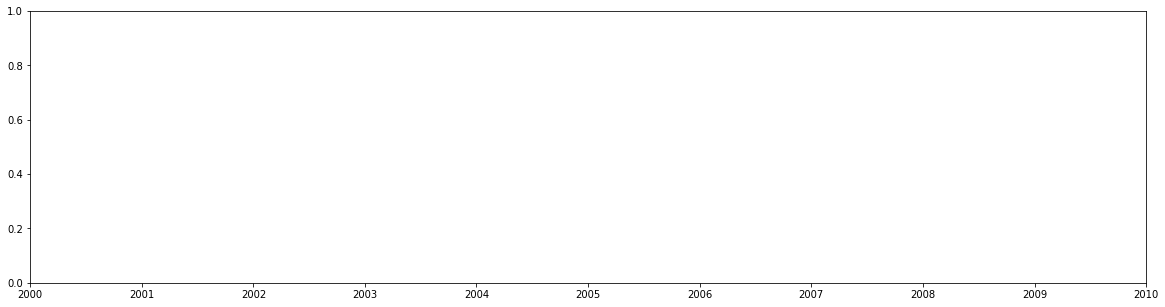

In [93]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

### XGBoosting

In [77]:
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree']},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [78]:
prob_predictions = xgboost.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, xgboost.predict_proba(df_validation_features), axis=0)

ValueError: x and y must have same first dimension, but have shapes (697,) and (2131,)

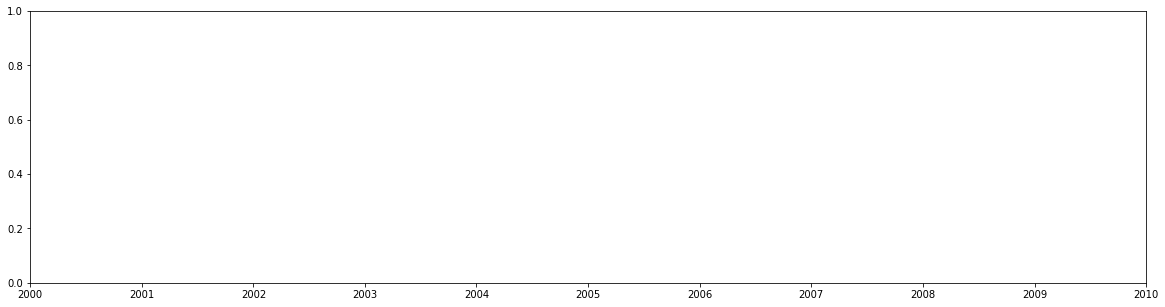

In [79]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
mp.savefig('plot3.png',  bbox_inches='tight')
plt.show()

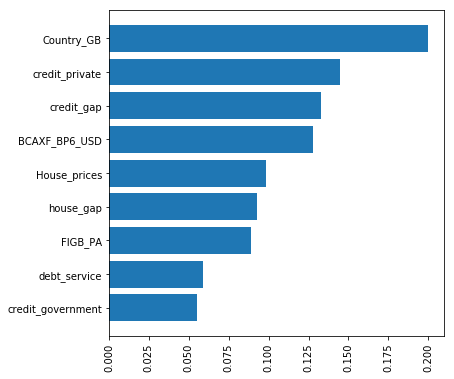

In [81]:
# find feature importances
headers = df.drop(['three_year', 'date'], axis=1).columns.values.tolist()
xgboost_importances = pd.DataFrame(xgboost.feature_importances_, index = headers, columns = ['Relative Importance'])
_ = xgboost_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
xgboost_importances = xgboost_importances[xgboost_importances['Relative Importance']>0].iloc[:20]

# display importances in bar-chart and pie-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(xgboost_importances)), width=xgboost_importances['Relative Importance'], align='center', tick_label=xgboost_importances.index)
plt.gca().invert_yaxis()
mp.savefig('feature_importance.png',  bbox_inches='tight')
plt.show()

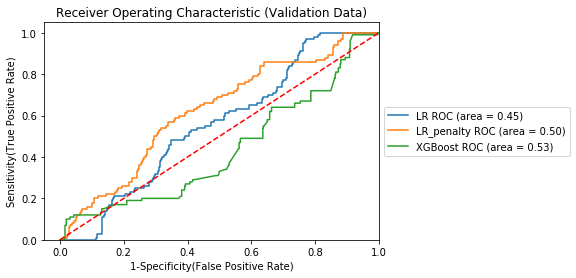

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR_penalty.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

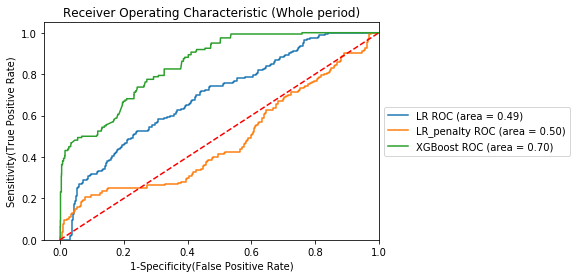

In [83]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))


fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR_penalty.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 